In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

Saving kaggle.json to kaggle.json
 96% 63.0M/66.0M [00:00<00:00, 141MB/s]
100% 66.0M/66.0M [00:00<00:00, 189MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [2]:
from matplotlib.colors import Normalize
import pandas as pd
from pandas.core.frame import DataFrame 
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.utils import shuffle
import seaborn as sns
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,classification_report,precision_score,recall_score,matthews_corrcoef,make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, ADASYN,RandomOverSampler,BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler,TomekLinks,NearMiss
from imblearn.combine import SMOTETomek
from matplotlib import gridspec
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def PCA_ALGO(X,y):
    #PREPARATION DES DONNEES
    tsne = TSNE(n_components=2,learning_rate=100,perplexity=50.0,early_exaggeration=20.0,init='pca')
    NEW_X=pd.DataFrame(data=X,columns=colonnes_X)
    NEW_X['Class']=pd.DataFrame(data=y,columns=colonnes_Y)
    X=shuffle(NEW_X)
    y=X.iloc[:,-1].values

    pca = PCA(n_components=2)
    pca_data=pca.fit_transform(X)
    print(pca_data.shape)
    pca_data=np.vstack((pca_data.T,y)).T
    print(pca_data.shape)
    print(pca_data)
    pca_df=pd.DataFrame(data=pca_data,columns=('PCA1','PCA2','Classe'))
    sns.FacetGrid(pca_df,hue='Classe',size=6).map(plt.scatter,'PCA1','PCA2').add_legend()
    plt.show()

def Distribution(X,y):
    #PREPARATION DES DONNEES
    tsne = TSNE(n_components=2,learning_rate=100,perplexity=50.0,early_exaggeration=20.0,init='pca')
    NEW_X=pd.DataFrame(data=X,columns=colonnes_X)
    NEW_X['Class']=pd.DataFrame(data=y,columns=colonnes_Y)
    #SNS COUNTPLOT
    fig,ax=plt.subplots(figsize=(5,5))
    sns.countplot(data=NEW_X,x="Class")
    plt.show()
def TSNE_algo(X,y):

    #PREPARATION DES DONNEES
    tsne = TSNE(n_components=2,learning_rate=100,perplexity=50.0,early_exaggeration=20.0,init='pca')
    NEW_X=pd.DataFrame(data=X,columns=colonnes_X)
    NEW_X['Class']=pd.DataFrame(data=y,columns=colonnes_Y)
    Fraude=NEW_X[NEW_X['Class']==1]
    Normal=NEW_X[NEW_X['Class']==0]
    Normal=Normal.iloc[0:10000] #pour prendre que 10000 transaction normale
    X=pd.concat([Normal,Fraude])
    X=shuffle(X)
    y=X.iloc[:,-1].values

    #TSNE
    x_test_2d = tsne.fit_transform(X)
    color_map = {0:'green', 1:'red'}
    plt.figure()
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = x_test_2d[y==cl,0], 
                    y = x_test_2d[y==cl,1], 
                    c = color_map[idx], 
                    label = cl)
    plt.xlabel('Composant t-SNE 1')
    plt.ylabel('Composant t-SNE 2')
    plt.legend(loc='upper left')
    plt.title('Représentation des données avec T-SNE')
    plt.show()


In [4]:
def random_forest_classifier_opti(X_tr,y_tr,X_ts,y_ts):
    #Classifier
    rf_classifier = RandomForestClassifier()
    # # Number of trees in random forest
    # n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # # Number of features to consider at every split
    # max_features = ['auto', 'sqrt','log2']
    # # Maximum number of levels in tree
    # max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    # max_depth.append(None)
    # # Minimum number of samples required to split a node
    # min_samples_split = [2, 5, 10]
    # # Minimum number of samples required at each leaf node
    # min_samples_leaf = [1, 2, 4]
    # # Method of selecting samples for training each tree
    # bootstrap = [True, False]
    param_grid = {
    'max_depth': [10,50, 110],
    'criterion':["gini"],
    'n_estimators': [100, 200,300]}
    # KFold
    cv = KFold(n_splits=5,random_state=None,shuffle=False)
    #Scorer
    mcc_score=make_scorer(matthews_corrcoef)
    #GRID SEARCH
    rf_clf=GridSearchCV(rf_classifier, param_grid, cv=cv, n_jobs=-1, scoring='recall')
    rf_clf.fit(X_tr,y_tr)
    print("les meilleurs hyperparamètres pour la regression logistique sont :{}".format(rf_clf.best_params_))
    y_pred = rf_clf.predict(X_ts)
    acc_score = rf_clf.score(X_tr, y_tr)
    print(f'SCORE DU MODELE :- {acc_score}')
    y_pred = rf_clf.predict(X_test)
    print('Accuracy :{0:0.5f}'.format(accuracy_score(y_pred, y_ts))) 
    print('Precision : {0:0.5f}'.format(precision_score(y_ts , y_pred)))
    print('Recall : {0:0.5f}'.format(recall_score(y_ts , y_pred)))
    print('F1 : {0:0.5f}'.format(f1_score(y_ts , y_pred)))
    print('matthews_corrcoef : {0:0.5f}'.format(matthews_corrcoef(y_ts , y_pred)))
    print(f"\\\\Matrice de confusion ///:- \n {confusion_matrix(y_ts, y_pred)}")
    sns.heatmap(pd.DataFrame(confusion_matrix(y_ts, y_pred)), annot=True, annot_kws={"size": 25}, cmap="winter" ,fmt='g')
    plt.title('Matrice de confusion', y=1.1, fontsize = 22)
    plt.xlabel('Prédit',fontsize = 18)
    plt.ylabel('Réel',fontsize = 18)
    plt.show()

In [5]:
df = pd.read_csv('creditcard.csv').astype(np.float32)
colonnes_X=['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

colonnes_Y=['Class']
Sc=StandardScaler()
Amount=df["Amount"].values
df["Amount"]=Sc.fit_transform(Amount.reshape(-1,1))
Time=df["Time"].values
df["Time"]=Sc.fit_transform(Time.reshape(-1,1))

x = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

********** AVANT ECHANTILLONAGE **********
transactions de la dataset X_TRAIN originale =Counter({0.0: 227454, 1.0: 391})
transactions de la dataset X_TEST originale =Counter({0.0: 56861, 1.0: 101})
les meilleurs hyperparamètres pour la regression logistique sont :{'criterion': 'gini', 'max_depth': 50, 'n_estimators': 200}
SCORE DU MODELE :- 1.0
Accuracy :0.99949
Precision : 0.91860
Recall : 0.78218
F1 : 0.84492
matthews_corrcoef : 0.84741
\\Matrice de confusion ///:- 
 [[56854     7]
 [   22    79]]


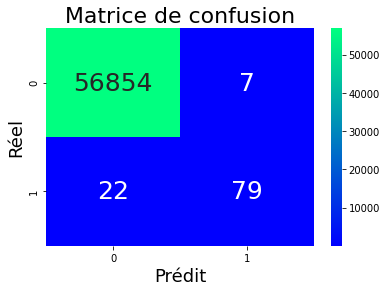

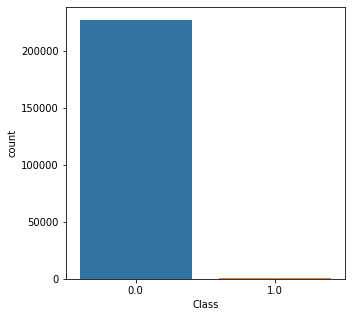

(227845, 2)
(227845, 3)
[[ 0.7146353  -0.78694654  0.        ]
 [-1.4168446  -0.08499704  0.        ]
 [-0.74452597  0.28291684  0.        ]
 ...
 [-0.41882908 -0.87943757  0.        ]
 [-2.0943549  -0.2639029   0.        ]
 [ 0.72077197 -0.6025124   0.        ]]


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


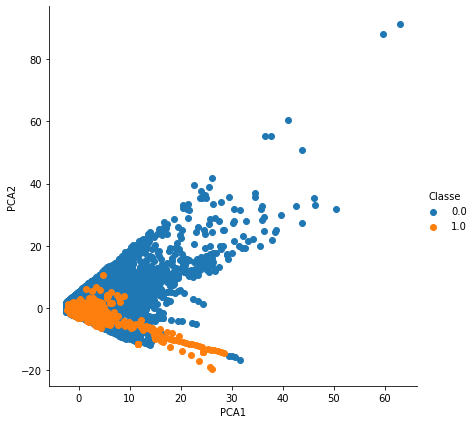

In [6]:
# #AVANT ECHANTILLONNAGE 
print("*"*10,"AVANT ECHANTILLONAGE","*"*10)
print("transactions de la dataset X_TRAIN originale ={}".format(Counter(Y_train)))
print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
random_forest_classifier_opti(X_train,Y_train,X_test,Y_test)
# #TSNE_algo(X_train,Y_train)
Distribution(X_train,Y_train)
PCA_ALGO(X_train,Y_train)
print("\n")

In [7]:
# # #APRES ECHANTILLONNAGE RANDOM UNDERSAMPLING
# print("*"*10,"APRES RANDOM UNDERSAMPLING","*"*10)
# rus=RandomUnderSampler()
# X_train_rus, y_train_rus = rus.fit_resample(X_train, Y_train)
# print("transactions de la X_TRAIN dataset apres RANDOM UNDERSAMPLING={}".format(Counter(y_train_rus)))
# print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
# random_forest_classifier(X_train_rus,y_train_rus,X_test,Y_test)
# Distribution(X_train_rus,y_train_rus)
# #TSNE_algo(X_train_rus,y_train_rus)
# PCA_ALGO(X_train_rus,y_train_rus)

In [8]:
# #APRES ECHANTILLONNAGE NearMiss
# nm=TomekLinks()
# X_train_nm, y_train_nm = nm.fit_resample(X_train, Y_train)
# print("transactions de la X_TRAIN dataset apres NearMiss={}".format(Counter(y_train_nm)))
# print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
# #random_forest_classifier(X_train_smt,y_train_smt,X_test,Y_test)
# random_forest_classifier(X_train_nm,y_train_nm,X_test,Y_test)
# Distribution(X_train_nm,y_train_nm)
# # TSNE_algo(X_train_bdsmote,y_train_bdsmote)
# PCA_ALGO(X_train_nm,y_train_nm)

In [9]:
# # # #APRES ECHANTILLONNAGE RANDOM OVERSAMPLING

# print("*"*10,"APRES RANDOM OVERSAMPLING","*"*10)
# ros=RandomOverSampler()
# X_train_ros, y_train_ros = ros.fit_resample(X_train, Y_train)
# print("transactions de la X_TRAIN dataset apres RANDOM OVERSAMPLING={}".format(Counter(y_train_ros)))
# print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
# random_forest_classifier(X_train_ros,y_train_ros,X_test,Y_test)
# Distribution(X_train_ros,y_train_ros)
# #TSNE_algo(X_train_ros,y_train_ros)
# PCA_ALGO(X_train_ros,y_train_ros)

In [10]:
# #APRES ECHANTILLONNAGE SMOTE
# smote = SMOTE()
# X_train_smote, y_train_smote = smote.fit_resample(X_train, Y_train)
# print("transactions de la X_TRAIN dataset apres SMOTE={}".format(Counter(y_train_smote)))
# print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
# random_forest_classifier(X_train_smote,y_train_smote,X_test,Y_test)
# Distribution(X_train_smote,y_train_smote)
# # TSNE_algo(X_train_smote,y_train_smote)
# PCA_ALGO(X_train_smote,y_train_smote)

In [11]:
# ##APRES ECHANTILLONNAGE ADASYN
# adasyn = ADASYN()
# X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, Y_train)
# print("transactions de la X_TRAIN dataset apres ADASYN={}".format(Counter(y_train_adasyn)))
# print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
# random_forest_classifier(X_train_adasyn,y_train_adasyn,X_test,Y_test)
# Distribution(X_train_adasyn,y_train_adasyn)
# # TSNE_algo(X_train_adasyn,y_train_adasyn)
# PCA_ALGO(X_train_adasyn,y_train_adasyn)

In [12]:
# # #APRES ECHANTILLONNAGE BorderlineSMOTE
# bdsmote = BorderlineSMOTE()
# X_train_bdsmote, y_train_bdsmote = bdsmote.fit_resample(X_train, Y_train)
# print("transactions de la X_TRAIN dataset apres BorderlineSMOTE={}".format(Counter(y_train_bdsmote)))
# print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
# random_forest_classifier(X_train_bdsmote,y_train_bdsmote,X_test,Y_test)
# Distribution(X_train_bdsmote,y_train_bdsmote)
# # TSNE_algo(X_train_bdsmote,y_train_bdsmote)
# PCA_ALGO(X_train_bdsmote,y_train_bdsmote)